In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Genetic Cipher in NLP refers to a method of encoding or transforming text using principles inspired by genetics (such as mutation, crossover, and selection), typically through genetic algorithms, to generate, evolve, or decrypt symbolic representations of language.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import string
import random
import re
import requests
import os
import textwrap

Creating a Substitution Cipher

In [2]:
### create substitution cipher
#  Generate a random one-to-one mapping from letters (a to z) — your cipher key.

# true_mapping: this dictionary acts as the substitution cipher for encoding messages.
# one will act as the key, other as the value
letters1 = list(string.ascii_lowercase)
letters2 = list(string.ascii_lowercase)

true_mapping = {}

# shuffle second set of letters
random.shuffle(letters2)

# populate map
for k, v in zip(letters1, letters2):
  true_mapping[k] = v

 Markov Model Initialization (Language Model)

In [3]:
### the language model
# M: Transition matrix that tracks how often one character follows another.

# pi: Initial distribution vector – tracks how often a character starts a word.

# These together form a bigram Markov language model.
# update_transition: Increments the count for transition from ch1 → ch2.

# update_pi: Increments the count for a character that starts a word.
# initialize Markov matrix
M = np.ones((26, 26))

# initial state distribution
pi = np.zeros(26)

# a function to update the Markov matrix
def update_transition(ch1, ch2):
  # ord('a') = 97, ord('b') = 98, ...
  i = ord(ch1) - 97
  j = ord(ch2) - 97
  M[i,j] += 1

# a function to update the initial state distribution
def update_pi(ch):
  i = ord(ch) - 97
  pi[i] += 1
# get_word_prob: Computes log-probability of a word based on pi and M.

# get_sequence_prob: Computes total log-probability of a sequence of words.
# get the log-probability of a word / token
def get_word_prob(word):
  # print("word:", word)
  i = ord(word[0]) - 97
  logp = np.log(pi[i])

  for ch in word[1:]:
    j = ord(ch) - 97
    logp += np.log(M[i, j]) # update prob
    i = j # update j

  return logp

# get the probability of a sequence of words
def get_sequence_prob(words):
  # if input is a string, split into an array of tokens
  if type(words) == str:
    words = words.split()

  logp = 0
  for word in words:
    logp += get_word_prob(word)
  return logp

In [7]:
### create a markov model based on an English dataset
# is an edit of https://www.gutenberg.org/ebooks/2701

import os

if not os.path.exists('moby_dick.txt'):
  print("Downloading moby dick...")
  # Use the correct method to read file from Google Drive in Colab:
  with open('/content/drive/MyDrive/Colab Notebooks2/NLP/lab9/moby_dick (1).txt', 'r') as f:
    content = f.read()
  with open('moby_dick.txt', 'w') as f:
    f.write(content)

Training the Markov Model

In [8]:
# Preprocesses and reads Moby Dick.

# Cleans the text, tokenizes it, updates the pi and M matrices.

# End Result: You now have a statistical model of English letter transitions.
# for replacing non-alpha characters
regex = re.compile('[^a-zA-Z]')

# load in words
for line in open('moby_dick.txt'):
  line = line.rstrip()

  # there are blank lines in the file
  if line:
    line = regex.sub(' ', line) # replace all non-alpha characters with space

    # split the tokens in the line and lowercase
    tokens = line.lower().split()

    for token in tokens:
      # update the model

      # first letter
      ch0 = token[0]
      update_pi(ch0)

      # other letters
      for ch1 in token[1:]:
        update_transition(ch0, ch1)
        ch0 = ch1

# normalize the probabilities
pi /= pi.sum()
M /= M.sum(axis=1, keepdims=True)

 Encode the Message

In [9]:
### encode a message
# Uses the true_mapping to replace each character.

# Spaces and non-alpha chars are preserved.
# this is a random excerpt from Project Gutenberg's
# The Adventures of Sherlock Holmes, by Arthur Conan Doyle
# https://www.gutenberg.org/ebooks/1661

original_message = '''I then lounged down the street and found,
as I expected, that there was a mews in a lane which runs down
by one wall of the garden. I lent the ostlers a hand in rubbing
down their horses, and received in exchange twopence, a glass of
half-and-half, two fills of shag tobacco, and as much information
as I could desire about Miss Adler, to say nothing of half a dozen
other people in the neighbourhood in whom I was not in the least
interested, but whose biographies I was compelled to listen to.
'''

# Away they went, and I was just wondering whether I should not do well
# to follow them when up the lane came a neat little landau, the coachman
# with his coat only half-buttoned, and his tie under his ear, while all
# the tags of his harness were sticking out of the buckles. It hadn't
# pulled up before she shot out of the hall door and into it. I only
# caught a glimpse of her at the moment, but she was a lovely woman, with
# a face that a man might die for.

# My cabby drove fast. I don't think I ever drove faster, but the others
# were there before us. The cab and the landau with their steaming horses
# were in front of the door when I arrived. I paid the man and hurried
# into the church. There was not a soul there save the two whom I had
# followed and a surpliced clergyman, who seemed to be expostulating with
# them. They were all three standing in a knot in front of the altar. I
# lounged up the side aisle like any other idler who has dropped into a
# church. Suddenly, to my surprise, the three at the altar faced round to
# me, and Godfrey Norton came running as hard as he could towards me.

In [10]:
# a function to encode a message
def encode_message(msg):
  # downcase
  msg = msg.lower()

  # replace non-alpha characters
  msg = regex.sub(' ', msg)

  # make the encoded message
  coded_msg = []
  for ch in msg:
    coded_ch = ch # could just be a space
    if ch in true_mapping:
      coded_ch = true_mapping[ch]
    coded_msg.append(coded_ch)

  return ''.join(coded_msg)


encoded_message = encode_message(original_message)

Decode the Message

In [11]:
# Given a key mapping (e.g., DNA mapping), tries to reconstruct the original message.
# a function to decode a message
def decode_message(msg, word_map):
  decoded_msg = []
  for ch in msg:
    decoded_ch = ch # could just be a space
    if ch in word_map:
      decoded_ch = word_map[ch]
    decoded_msg.append(decoded_ch)

  return ''.join(decoded_msg)

Genetic Algorithm to Break the Cipher

In [12]:
### run an evolutionary algorithm to decode the message

# this is our initialization point
dna_pool = []
for _ in range(20):
  dna = list(string.ascii_lowercase)
  random.shuffle(dna)
  dna_pool.append(dna)

Genetic Algorithm to Break the Cipher

In [13]:
# Generates children by randomly swapping letters (i.e., mutations).

# Classic genetic algorithm step.
# Scores each candidate solution (permutation) using the Markov model.

# Keeps the best candidates for the next generation (elitism).
def evolve_offspring(dna_pool, n_children):
  # make n_children per offspring
  offspring = []

  for dna in dna_pool:
    for _ in range(n_children):
      copy = dna.copy()
      j = np.random.randint(len(copy))
      k = np.random.randint(len(copy))

      # switch
      tmp = copy[j]
      copy[j] = copy[k]
      copy[k] = tmp
      offspring.append(copy)

  return offspring + dna_pool

In [14]:
num_iters = 1000
scores = np.zeros(num_iters)
best_dna = None
best_map = None
best_score = float('-inf')
for i in range(num_iters):
  if i > 0:
    # get offspring from the current dna pool
    dna_pool = evolve_offspring(dna_pool, 3)

  # calculate score for each dna
  dna2score = {}
  for dna in dna_pool:
    # populate map
    current_map = {}
    for k, v in zip(letters1, dna):
      current_map[k] = v

    decoded_message = decode_message(encoded_message, current_map)
    score = get_sequence_prob(decoded_message)

    # store it
    # needs to be a string to be a dict key
    dna2score[''.join(dna)] = score

    # record the best so far
    if score > best_score:
      best_dna = dna
      best_map = current_map
      best_score = score

  # average score for this generation
  scores[i] = np.mean(list(dna2score.values()))

  # keep the best 5 dna
  # also turn them back into list of single chars
  sorted_dna = sorted(dna2score.items(), key=lambda x: x[1], reverse=True)
  dna_pool = [list(k) for k, v in sorted_dna[:5]]

  if i % 200 == 0:
    print("iter:", i, "score:", scores[i], "best so far:", best_score)

iter: 0 score: -2113.6135267894124 best so far: -1645.9703103128088
iter: 200 score: -1022.8061884022709 best so far: -929.5902922650557
iter: 400 score: -1015.8528861011482 best so far: -929.5902922650557
iter: 600 score: -1034.7007933637647 best so far: -929.5902922650557
iter: 800 score: -1028.8130177323817 best so far: -929.5902922650557


In [15]:
# use best score
decoded_message = decode_message(encoded_message, best_map)

print("LL of decoded message:", get_sequence_prob(decoded_message))
print("LL of true message:", get_sequence_prob(regex.sub(' ', original_message.lower())))


# which letters are wrong?
for true, v in true_mapping.items():
  pred = best_map[v]
  if true != pred:
    print("true: %s, pred: %s" % (true, pred))

LL of decoded message: -929.5902922650557
LL of true message: -933.0312453751817
true: k, pred: z
true: z, pred: k


In [16]:
# print the final decoded message
print("Decoded message:\n", textwrap.fill(decoded_message))

print("\nTrue message:\n", original_message)

Decoded message:
 i then lounged down the street and found  as i expected  that there
was a mews in a lane which runs down by one wall of the garden  i lent
the ostlers a hand in rubbing down their horses  and received in
exchange twopence  a glass of half and half  two fills of shag tobacco
and as much information as i could desire about miss adler  to say
nothing of half a doken other people in the neighbourhood in whom i
was not in the least interested  but whose biographies i was compelled
to listen to

True message:
 I then lounged down the street and found,
as I expected, that there was a mews in a lane which runs down
by one wall of the garden. I lent the ostlers a hand in rubbing
down their horses, and received in exchange twopence, a glass of
half-and-half, two fills of shag tobacco, and as much information
as I could desire about Miss Adler, to say nothing of half a dozen
other people in the neighbourhood in whom I was not in the least
interested, but whose biographies I was 

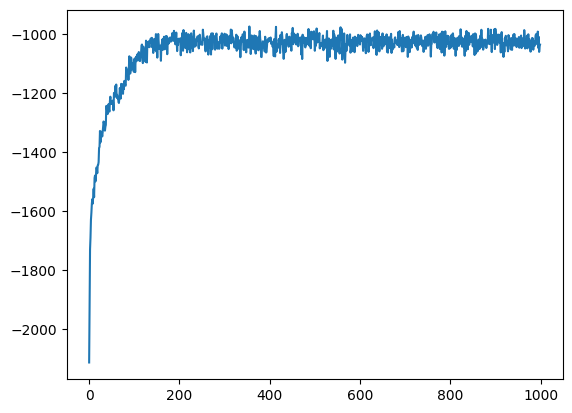

In [17]:
plt.plot(scores)
plt.show()

Enhanced Mutate method

In [26]:
import random
import string

def mutate_dna(dna, mutation_rate=0.01):
    """Mutates a DNA sequence with more variation.

    Args:
        dna: A list representing the DNA sequence (permutation of letters).
        mutation_rate: The probability of a mutation occurring for a single letter.

    Returns:
        A new list representing the mutated DNA sequence.
    """
    new_dna = dna.copy()
    dna_len = len(new_dna)  # Store initial length of new_dna
    for i in range(dna_len):  # Use dna_len to keep track of original length
        if random.random() < mutation_rate:
            # Swap mutation (original)
            j = random.randint(0, len(new_dna) - 1)  # Now that new_dna is dynamically changed, update j as well
            try:                                    # Add a try-except block to handle potential index errors
                new_dna[i], new_dna[j] = new_dna[j], new_dna[i]
            except IndexError:
                # Handle the error, e.g., skip the current iteration or pass
                # or simply break out of the loop
                break # breaking out of the for loop if the new_dna[i] or new_dna[j] is out of range
                #pass  # Or you can choose to ignore this error and continue

        elif random.random() < mutation_rate * 0.5:  # Insert mutation
            if len(new_dna) < len(string.ascii_lowercase):  # avoid index error if new_dna is already full length
                j = random.randint(0, len(new_dna))  # insert at random position #Fixed code, allows insert at end
                # value can be random letter but should not already be in list to maintain permutation.
                insert_value = random.choice(list(set(string.ascii_lowercase) - set(new_dna)))
                new_dna.insert(j, insert_value)

        elif random.random() < mutation_rate * 0.3:  # delete mutation
            if len(new_dna) > 1:  # make sure new_dna is not empty after deletion.
                # delete at a random position
                del new_dna[random.randint(0, len(new_dna) - 1)]

        elif random.random() < mutation_rate * 0.2:  # Inversion mutation
            # select a sublist from new_dna and reverse it
            start = random.randint(0, len(new_dna) - 2)  # start index
            end = random.randint(start + 1, len(new_dna))  # end index
            new_dna[start:end] = new_dna[start:end][::-1]  # Reverse the selected sublist
    return new_dna

In [27]:
def evolve_offspring(dna_pool, n_children):
  # make n_children per offspring
  offspring = []

  for dna in dna_pool:
    for _ in range(n_children):
      # Apply the new mutation function here:
      copy = mutate_dna(dna.copy())
      offspring.append(copy)

  return offspring + dna_pool

In [28]:
num_iters = 1000
scores = np.zeros(num_iters)
best_dna = None
best_map = None
best_score = float('-inf')
for i in range(num_iters):
  if i > 0:
    # get offspring from the current dna pool
    dna_pool = evolve_offspring(dna_pool, 3)

  # calculate score for each dna
  dna2score = {}
  for dna in dna_pool:
    # populate map
    current_map = {}
    for k, v in zip(letters1, dna):
      current_map[k] = v

    decoded_message = decode_message(encoded_message, current_map)
    score = get_sequence_prob(decoded_message)

    # store it
    # needs to be a string to be a dict key
    dna2score[''.join(dna)] = score

    # record the best so far
    if score > best_score:
      best_dna = dna
      best_map = current_map
      best_score = score

  # average score for this generation
  scores[i] = np.mean(list(dna2score.values()))

  # keep the best 5 dna
  # also turn them back into list of single chars
  sorted_dna = sorted(dna2score.items(), key=lambda x: x[1], reverse=True)
  dna_pool = [list(k) for k, v in sorted_dna[:5]]

  if i % 200 == 0:
    print("iter:", i, "score:", scores[i], "best so far:", best_score)

iter: 0 score: -929.5902922650557 best so far: -929.5902922650557
iter: 200 score: -962.4453997166104 best so far: -929.5902922650557
iter: 400 score: -980.7771547051993 best so far: -929.5902922650557
iter: 600 score: -1239.6846138780106 best so far: -929.5902922650557
iter: 800 score: -1073.7010200734653 best so far: -929.5902922650557


In [29]:
# use best score
decoded_message = decode_message(encoded_message, best_map)

print("LL of decoded message:", get_sequence_prob(decoded_message))
print("LL of true message:", get_sequence_prob(regex.sub(' ', original_message.lower())))


# which letters are wrong?
for true, v in true_mapping.items():
  pred = best_map[v]
  if true != pred:
    print("true: %s, pred: %s" % (true, pred))

LL of decoded message: -929.5902922650557
LL of true message: -933.0312453751817
true: j, pred: z
true: k, pred: q
true: q, pred: j
true: z, pred: k


In [30]:
# print the final decoded message
print("Decoded message:\n", textwrap.fill(decoded_message))

print("\nTrue message:\n", original_message)

Decoded message:
 i then lounged down the street and found  as i expected  that there
was a mews in a lane which runs down by one wall of the garden  i lent
the ostlers a hand in rubbing down their horses  and received in
exchange twopence  a glass of half and half  two fills of shag tobacco
and as much information as i could desire about miss adler  to say
nothing of half a doken other people in the neighbourhood in whom i
was not in the least interested  but whose biographies i was compelled
to listen to

True message:
 I then lounged down the street and found,
as I expected, that there was a mews in a lane which runs down
by one wall of the garden. I lent the ostlers a hand in rubbing
down their horses, and received in exchange twopence, a glass of
half-and-half, two fills of shag tobacco, and as much information
as I could desire about Miss Adler, to say nothing of half a dozen
other people in the neighbourhood in whom I was not in the least
interested, but whose biographies I was 